Import modules

In [1]:
import numpy as np
import pandas
from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from datetime import datetime
import time

Load data from CSV file

In [2]:
df = pandas.read_csv('data/brand3.csv')
print(df)

             volt  current   soc  max_single_volt  min_single_volt  max_temp  \
0        38.85350   -19.52  27.0           3.6323           3.6183      22.0   
1        38.85707   -19.70  27.0           3.6351           3.6211      22.0   
2        38.89158   -19.70  27.0           3.6362           3.6221      22.0   
3        38.91300   -19.71  27.0           3.6380           3.6230      22.0   
4        38.91300   -19.79  27.0           3.6381           3.6231      22.0   
...           ...      ...   ...              ...              ...       ...   
3788539  44.35130   -48.35  88.0           4.1520           4.0991      32.0   
3788540  44.35368   -48.86  88.0           4.1521           4.1001      32.0   
3788541  44.37510   -49.32  88.0           4.1531           4.1011      32.0   
3788542  44.37867   -48.67  88.0           4.1542           4.1021      32.0   
3788543  44.41080   -49.20  88.0           4.1561           4.1032      32.0   

         min_temp  timestamp  label  ca

Clean up data

In [3]:
df = df.dropna()

# df = df.loc[(df['car'] == 455) | (df['car'] == 405)] # TODO: Small sample for testing purposes

df = df.drop(columns=['car'], axis=1)
print("Remaining rows:", df.shape)

Remaining rows: (3788544, 10)


Normalize data

In [4]:
# normalize all columns
for column in df.columns:
    if column != 'label':
        df[column] = (df[column] - df[column].mean()) / df[column].std()

Seperate inputs and outputs

In [5]:
X = np.array(df.drop(['label'], axis=1))
Y = np.array(df['label'])
print(X.shape)
print(Y.shape)

(3788544, 9)
(3788544,)


Split training and testing data

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
print("Training X:", X_train.shape)
print("Training Y:", Y_train.shape)
print("Validation X:", X_val.shape)
print("Validation Y:", Y_val.shape)
print("Testing X:", X_test.shape)
print("Testing Y:", Y_test.shape)

Training X: (2424668, 9)
Training Y: (2424668,)
Validation X: (606167, 9)
Validation Y: (606167,)
Testing X: (757709, 9)
Testing Y: (757709,)


Process data

In [7]:
class Data(Dataset):
  def __init__(self, X_train, y_train):
    # need to convert float64 to float32 else will get the following error
    # RuntimeError: expected scalar type Double but found Float
    self.X = torch.from_numpy(X_train.astype(np.float32))

    # need to convert float64 to Long else will get the following error
    # RuntimeError: expected scalar type Long but found Float
    self.y = torch.from_numpy(y_train).type(torch.LongTensor)
    self.len = self.X.shape[0]
  
  def __getitem__(self, index):
    return self.X[index], self.y[index]
  
  def __len__(self):
    return self.len

Load training and validation data

In [8]:
traindata = Data(X_train, Y_train)
print("traindata size:", len(traindata))

valdata = Data(X_val, Y_val)
print("valdata size:", len(valdata))

batch_size = 256

trainloader = DataLoader(traindata, batch_size=batch_size, shuffle=True, num_workers=0)
print("trainloader size:", len(trainloader))

valloader = DataLoader(valdata, batch_size=batch_size, shuffle=True, num_workers=0)
print("valloader size:", len(valloader))

traindata size: 2424668
valdata size: 606167
trainloader size: 9472
valloader size: 2368


Build Simple NN

In [9]:
# number of features (len of X cols)
input_dim = X.shape[1]
print("Input dim:", input_dim)

# number of classes (unique of y)
output_dim = len(np.unique(Y))
print("Output dim:", output_dim)

class Network(nn.Module):
  def __init__(self):
    super(Network, self).__init__()
    self.lienar_sigmoid_stack = nn.Sequential(
      nn.Linear(input_dim, 64),
      nn.Sigmoid(),
      nn.Linear(64, 32),
      nn.Sigmoid(),
      nn.Linear(32, 16),
      nn.Sigmoid(),
      nn.Linear(16, output_dim)
    )

  def forward(self, x):
    x = self.lienar_sigmoid_stack(x)
    return x

Input dim: 9
Output dim: 2


Initialize classifier

In [10]:
clf = Network()
print(clf.parameters)

<bound method Module.parameters of Network(
  (lienar_sigmoid_stack): Sequential(
    (0): Linear(in_features=9, out_features=64, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)>


Define loss funciton and optimizer

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(clf.parameters(), lr=0.1, momentum=0.9)

Training

In [12]:
epochs = 32
train_accuracy = []
val_accuracy = []

for epoch in range(epochs):
  epcoh_start = time.time()
  running_loss = 0.0
  train_correct, train_total = 0, 0

  for data in trainloader:
    inputs, labels = data

    # set optimizer to zero grad to remove previous epoch gradients
    optimizer.zero_grad()

    # forward propagation
    outputs = clf(inputs)
    loss = criterion(outputs, labels)

    # backward propagation
    loss.backward()

    # optimize
    optimizer.step()
    running_loss += loss.item()

    # get training accuracy
    _, predicted = torch.max(outputs, 1)
    train_total += labels.size(0)
    train_correct += (predicted == labels).sum().item()

  train_accuracy.append(train_correct / train_total)

  val_correct, val_total = 0, 0
  with torch.no_grad():
    for data in valloader:

      inputs, labels = data

      outputs = clf(inputs)
      
      _, predicted = torch.max(outputs, 1)

      val_total += labels.size(0)
      val_correct += (predicted == labels).sum().item()
  
  val_accuracy.append(val_correct / val_total)
  print(f"Epoch: {epoch + 1}, Training Accuracy: {np.round(train_accuracy[-1], 4)}, Validation Accuracy: {np.round(val_accuracy[-1], 4)}")
  print(f"Time taken: {time.time() - epcoh_start}")
  

Epoch: 1, Training Accuracy: 0.9445, Validation Accuracy: 0.9505
Time taken: 15.172545194625854
Epoch: 2, Training Accuracy: 0.9529, Validation Accuracy: 0.9551
Time taken: 15.011320114135742
Epoch: 3, Training Accuracy: 0.9583, Validation Accuracy: 0.9606
Time taken: 15.662709951400757
Epoch: 4, Training Accuracy: 0.9614, Validation Accuracy: 0.963
Time taken: 15.32950210571289
Epoch: 5, Training Accuracy: 0.9642, Validation Accuracy: 0.9659
Time taken: 15.356574773788452
Epoch: 6, Training Accuracy: 0.966, Validation Accuracy: 0.9672
Time taken: 15.806411027908325
Epoch: 7, Training Accuracy: 0.9676, Validation Accuracy: 0.966
Time taken: 15.708585977554321
Epoch: 8, Training Accuracy: 0.9687, Validation Accuracy: 0.9707
Time taken: 15.005706071853638
Epoch: 9, Training Accuracy: 0.9698, Validation Accuracy: 0.9708
Time taken: 15.146419048309326
Epoch: 10, Training Accuracy: 0.971, Validation Accuracy: 0.9734
Time taken: 15.889940977096558
Epoch: 11, Training Accuracy: 0.9728, Valida

Plot training loss over time

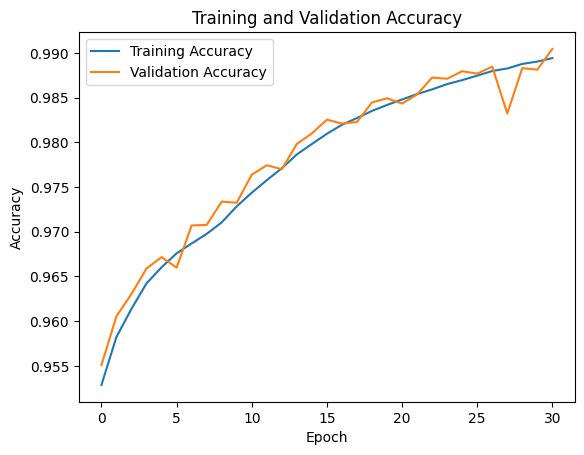

In [13]:
# plot training and validation accuracy over epochs
plt.plot(train_accuracy[1:], label='Training Accuracy')
plt.plot(val_accuracy[1:], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

Save the trained model

In [14]:
# save model with timestamp in file name
model_timestamp = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
model_path = './models/v1_simple/results/' + model_timestamp + '.pth'
torch.save(clf.state_dict(), model_path)

Loading trained model

In [15]:
clf = Network()
clf.load_state_dict(torch.load(model_path))

<All keys matched successfully>

Testing trained model

In [16]:
testdata = Data(X_test, Y_test)
testloader = DataLoader(testdata, batch_size=batch_size, shuffle=True, num_workers=0)

Get proportions of 0s and 1s in test set

In [17]:
unique, counts = np.unique(Y_test, return_counts=True)
print(dict(zip(unique, counts)))
print("Proportion of 0s:", counts[0] / len(Y_test))
print("Proportion of 1s:", counts[1] / len(Y_test))

{0: 712036, 1: 45673}
Proportion of 0s: 0.9397222416521382
Proportion of 1s: 0.060277758347861775


Get testing accuracy

In [18]:
correct, total = 0, 0

# no need to calculate gradients during inference
with torch.no_grad():
  for data in testloader:
    inputs, labels = data

    # calculate output by running through the network
    outputs = clf(inputs)

    # get the predictions
    __, predicted = torch.max(outputs.data, 1)

    # update results
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the {len(testdata)} test data: {100 * correct / total} %')

Accuracy of the network on the 757709 test data: 99.04132061253067 %
